## Final Project Submission
* Student name: Pedro Jofre Lora
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Eli Thomas
* Blog post URL: 

### The Deliverables
The goal of your project is to query the database to get the data needed to perform a statistical analysis. In this statistical analysis, you'll need to perform a hypothesis test (or perhaps several) to answer the following question:

Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

In addition to answering this question with a hypothesis test, you will also need to come up with at least 3 other hypotheses to test on your own. These can by anything that you think could be imporant information for the company.

For this hypothesis, be sure to specify both the null hypothesis and the alternative hypothesis for your question. You should also specify if this is one-tail or a two-tail test

# Making recommendations to the Northwind Trading Company to improve performance based on hypothesis testing using frequentist and bayesian methods. 
### Table of Contents
1. [Introduction](#1) <br>
2. [Previewing Data](#2) <br>
3. [Forming Questions for Analysis](#3) <br>
4. [A Reminder on Hypothesis Statements](#4) <br>
5. [Do Discounts Increase Order Volume](#5) <br>
6. [Do Discounts Increase the Gross Profit of an Order?](#6)

<a id="1"></a>
## 1. Introduction

<a id="2"></a>
## 2. Previewing Data
Given that Northwind Trading Company is a fictitious entity, I need to look at the example data that is stored in the database in order to orient myself and begin to ask meaningful questions. I will look at the first 10 or so entries of every table in the database without being selective of the data. The function will also let me look at some of the metadata and the properties of the dataframe.

In [1]:
import pandas as pd
import sqlite3 as sql
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from ipywidgets import interact, interactive
# I'll learn to use plotly in this project since there's a lot of talk about how much more powerful it is than matplotlib.

In [2]:
# Open a connection to the sql server. I'll use sqlite3 for now, but I may switch to another sql module later if I need it.
connect = sql.connect('Northwind_small.sqlite')
c = connect.cursor()
# Get table names
raw = c.execute("""select name from sqlite_master where type = 'table'""").fetchall()
tables = []
for table in raw:
    tables.append(table[0])

In [3]:
@interact
def table_preview(Table = tables, Preview = ['Head','Description', 'Shape','Unique','Types']):
    statement = "SELECT * FROM [" + Table + "]"
    df = pd.read_sql_query(statement, connect)
    preview_return = {'Head':df.head(10), 'Description':df.describe(), 
                      'Shape':df.shape, 'Unique':df.nunique(axis = 0), 'Types':df.dtypes}
    out = preview_return[Preview]
    return out

interactive(children=(Dropdown(description='Table', options=('Employee', 'Category', 'Customer', 'Shipper', 'S…

The following is an overview of the available, pertinent data:
*  **Employees**
    - There are 9 employees. 5 are in the USA, and 4 are in the UK
    - The notes include information about education
    - The hire date is likely incorrect, since the data is in the future (2024) and the order dates are in 2012.
*  **Categories**
    - Northwind Trading Company trades in food products
    - There are 8 categories of food products
*  **Customers**
    - There are 91 customers
    - Contact Title may be interesting to explore (e.g. President, Sales Rep). There are 12 unique values
    - Region and Country may also be interesting to explore. There are 9 regions and 21 countries
*  **Shipper**
    - There are three shippers
*  **Suppliers**
    - There are 29 suppliers
    - The suppliers are scattered globally in 11 distinct regions
*  **Orders**
    - There are 830 orders
    - Only 89 customers have made purchases
    - There are only 387 confirmed ship dates. This is concerning...
*  **Products**
    - There are 77 unique products, 2 of which are discontinued
    - 62 products have unit prices
*  **Order Details**
    - There are a total of 2155 unique product orders. These represent the products that were ordered in the 830 customer orders.
    - The discount information resides in the Order Details
    - There are more Unit Prices than unique products, which is a signal that either 1) customers receive different unit prices, or 2) Unit Prices include the applied discount
*  **Territories and Regions**
    - There are 4 nondescript territories, and 52 unique regions.
    - Only 49 territories are assigned to employees
*  **There Are No Customer Demographic Data**
    


<a id="3"></a>
## 3. Forming Questions for Analysis

Let's assume that we're consultants tasked with improving the performance of the Northwind Trading Company by giving broad recommendations about new procedures to implement. These procedures could involve anything from the rate and frequency of discounts, to the distribution of employees to customers. In order to give recommendations, we should look to determine what differences, if any, exist between a set of conditions. We can, and should, try to control for other factors whenever possible.

It is helpful to identify the metrics by which to measure success in order to narrow the field of questions that can be asked. The important metrics of success, or performance, are the following listed from most to least important:
1. Gross Profit (Greater is better)
2. Gross Profit Margin (Greater is better)
3. Order Regularity as measured by variability (Lesser is better)
4. Order Volume (Greater is better)
5. Customer Satisfaction as measured by a synthetic analog (e.g. shipping times) (Greater is Better)
6. Employee Productivity as measured by a synthetic analog (e.g. profit normalized by number of assigned customers) (Greater is Better)

We must assume that the order of importance listed above aligns with the Northwind Trading Company. In reality, the metrics of success would likely be codeveloped between the client and the consultant to ensure that the expectations about the results are congruent between both parties. The consultant brings information into the equation that the client may be blind to (e.g. knowledge from other industries, best practices, etc), just as the client brings information into the equation that the consultant simply cannot know (e.g. the values of the business, the vision, etc). The above list represents a likely way that a corporate entity would prioritize success.

Having defined the metrics that can be measured, it is now possible to begin to ask questions that will likely modify those metrics. Some questions are listed below in association with their metric. This is not an exhaustive list, and again some of these questions would be coconstructed with the client:

1. Gross Profit
    - Do discounts improve the profit of an order? 
    - Does any one category produce more profit than every other on a per order basis? 
    - Does any one employee produce more profit than every other on a per order basis?
    - Are there month(s) of the year that produce more profit?
    - Does a customer with a higher corporate rank (e.g. President vs Associate) produce more profit?
2. Gross Profit Margin
    - Does any one category produce a higher profit margin than every other after accounting for order quantities?
    - Does any one supplier have a higher profit margin than every other supplier?
3. Order Regularity
    - Does any one employee have more order regularity than every other employee?
    - Is any one product category more regular than every other?
    - Does any one region order with more regularity than every other region?
4. Order Volume
    - Do discounts increase order volume?
        - Are discounts more successful in certain regions at increasing order volume?
    - Does any one customer have a higher order volume more than every other?
    - Is any one supplier's foods favored?
5. Customer Satisfaction
    - Does customer satisfaction impact gross profits?
6. Employee Productivity
    - Does any one employee produce more orders after normalizing for their number of customers?
   

Each of the above questions can be followed up by asking, "if so, to what extent is there a difference?" It is important to determine that there is, in fact, a statistical difference in the first place before jumping to conclusions, which is why each question is asked as a binary event.

For the sake of this notebook, I will attend to four of the above questions to show the kind of work that is necessary in order to perform the full analysis. Two of the questions will be answered using a frequentist approach (e.g. two-sample t-test of means), while the other two questions will be answered using a bayesian approach. Each question will be answered in its own section (Sections 5-8).

<a id="4"></a>
## 4. A Reminder on Hypothesis Statements

Statistical significance requires that a null hypothesis, H$_0$, be evaluated in the context of an alternative hypothesis, H$_a$, and a prescribed tolerance for rejecting the null hypothesis, $\alpha$. It is customary to set $\alpha$ at 0.05, which indicates that we must have "95% confidence" in rejecting our assumptions. The $\alpha$ value represents more than our confidence; it represents the likelihood of Type I error (and by extension the Type II error), the probability of producing the current findings in a prescribed probability distribution, and a measure of the difference between samples (or groups of samples) given a standard deviation. An $\alpha$ value of 0.05 balances Type I and Type II errors, and represents almost 4 standard deviations to the left and right of the expected value as prescribed in the null hypothesis. $\alpha$ = 0.05 will be used for the entirety of this anaylsis.

One final note about hypothesis statements: In any statistical test, *the goal is to reject the null hypothesis* in order to demonstrate that there is little evidence to believe that a certain relationship exists between two samples. The null hypothesis is thus the relationship that we want to claim is **False** between our two samples. Rejecting the null hypothesis does not mean that we accept the alternative hypothesis. It simply means that we reject the null hypothesis and offer the alternative hypothesis as a reasonable alternative. It is often the goal to make the alternative hypothesis the *only possible alternative hypothesis*, in which case we must accept the alternative hypothesis if we reject the null hypothesis.

<a id="5"></a>
## 5. Do discounts increase order volume?

### 5.1 Hypothesis statement
I am interested in determining if discounts have an impact on the volume of a product that is ordered. Intuition tells me that discounts modify behavior, so I expect that there will be a difference. As such, I am comparing if the *average volume sold of a product, or in a transaction, is equal to or less in the context of a discount*. The null hypothesis, the hypothesis that I hope to reject, is that there is at most no difference in order volume despite discounts. The alternative hypothesis is that there is a difference.

<center> H$_0$: $\mu_{O|D}$ ≤ $\mu_{O|ND}$ </center>
<center>H$_a$: $\mu_{O|D}$ > $\mu_{O|ND}$</center>
Where:<br>
$\mu_{O|ND}$ $\equiv$ The average number of products a customer orders in a transaction given that there are no discounts.<br>
$\mu_{O|D}$ $\equiv$ The average number of products a customer orders in a transaction given that there are discounts.<br><br>
This is a one-tailed test, since I am only interested in determining if discounts increase the order volume. I could ask instead if there is a difference, but I'll cut straight to the chase for this analysis.


I will check two scenarios. One in which the volume of a *specific product* is different in the context of a discount, and another in which the volume of a *specific order* is different inn the context of any discounted item in that order. Both of these are described well by the null and alternative hypotheses without their modification, though if it is necessary to be rigorous than the definitions could be explained as such.

### 5.2 Gathering Data

In [4]:
# Obtain data to assess whether products are ordered in higher volumes if discounted
d_product_statement = """SELECT ProductId, Quantity, Discount
                         FROM OrderDetail
                         WHERE Discount > 0"""
nd_product_statement = """SElECT ProductId, Quantity, Discount
                          FROM OrderDetail
                          WHERE Discount == 0"""
d_product = pd.read_sql_query(d_product_statement,connect)
nd_product = pd.read_sql_query(nd_product_statement,connect)

In [5]:
# Obtain data to assess whether orders have higher volume if a product is discounted
# Note that these SQL queries are nested. The primary SQL query requests data from the nested SQL query based on a condition of a value in the nested query. This allows me to return the min and max discounts in an order while aggregating the order quantity correctly.
d_order_statement = """SELECT OrderId, 
                              Quantity, 
                              MaxDiscount, 
                              MinDiscount
                       FROM (
                            SELECT OrderId,
                                   SUM(Quantity) as Quantity,
                                   MAX(Discount) AS MaxDiscount,
                                   MIN(Discount) AS MinDiscount
                            FROM OrderDetail
                            GROUP BY OrderId
                            )
                       WHERE MaxDiscount > 0
                       GROUP BY OrderId"""

nd_order_statement ="""SELECT OrderId, 
                              Quantity, 
                              MaxDiscount, 
                              MinDiscount
                       FROM (
                            SELECT OrderId,
                                   SUM(Quantity) as Quantity,
                                   MAX(Discount) AS MaxDiscount,
                                   MIN(Discount) AS MinDiscount
                            FROM OrderDetail
                            GROUP BY OrderId
                            )
                       WHERE MaxDiscount == 0
                       GROUP BY OrderId"""
statements = [d_order_statement,nd_order_statement]
df = []
for statement in statements:
    raw = c.execute(statement)
    data = raw.fetchall()
    columns = raw.description
    temp = pd.DataFrame(data)
    temp.columns = [column[0] for column in columns]
    df.append(temp)

d_order = df[0]
nd_order = df[1]

### 5.3 Do discounts increase the order volume of a specific product?
In order to test this hypothesis, I'll perform a one-way repeated-measures (within group) t-test. This test checks to see if the order quantity is greater for each specific product when there is a discount. Since each product is likely ordered at a different rate, I cannot simply compare the means of the whole population. This test is equivalent to asking if a certain drug helps lower blood pressure in a group of people. They may not all have the same blood pressure to start, so the test asks if the group experienced a decrease from their *individual baseline* blood pressure, instead of asking if the group as a whole had a lower blood pressure at the end.<br>
The one-way repeated measures t-test is equivalent to the one-sample t-test, but it uses the differences within samples before and after treatment as the sample. Said plainly,  I'm looking to see if the difference is statistically significantly greater than 0. Unfortunately, repeated measures require that the datasets be balanced in a 1:1 ratio, so I'll use the mean volume of orders for each product as the measure to ensure this requirement is met.

In [6]:
# Import statistical package for Repeated Measured Anova
from scipy.stats import ttest_1samp
# Obtain difference in mean between the same products
d_product_mean = d_product.groupby('ProductId').Quantity.mean()
nd_product_mean = nd_product.groupby('ProductId').Quantity.mean()
d_nd_diff = d_product_mean-nd_product_mean
# Run One-way Anova
results = ttest_1samp(d_nd_diff,0)

Since ttest_1samp calculates a two-tailed t-test, I must interpret the results. The one-tailed t-test results can be inferred from the two-tailed results: the level of significance that must be met is p < 2•$\alpha$, and t > 0. In this case, both are true, so we reject the null hypothesis that discounts produce fewer or equal number of orders, and accept the alternative hypothesis that **discounts increase the number of orders for a given product**.<br>
The effect size is computed using Cohen's d estimate as prescribed in the original publication:<br><br>
<center>d = $\frac{\mu_1-\mu_2}{s}$ </center>
<br>
<center>s = $\sqrt{\frac{(n_1-1)s_1^2+(n_2-1)s_2^2}{n_1+n_2-2}}$ </center>
<br>
This is done 'by hand' below.

In [7]:
s = np.sqrt(((len(d_nd_diff)-1)*d_nd_diff.std()**2+0)/(len(d_nd_diff)-2))
d = (d_nd_diff.mean()-0)/s
print("Cohen's d = {0:1.3f}".format(d))

Cohen's d = 0.493


According to Cohen, this is a medium effect size.

### 5.4 Do discounts increase the order volume of individual orders?
This analysis is simpler since I'm comparing the average total volume of an order with and without discounts. I can't control for which items make it into the basket because the number of possible combinations would likely leave me with one sample in each unique order composition. I'll simply look at whether or not orders that contain at least one item with a discount have greater volume than those that don't. This is a two-sample, one-tailed t-test.

In [8]:
from statsmodels.stats.weightstats import ttest_ind
t, p, df = ttest_ind(d_order.Quantity, nd_order.Quantity, alternative = 'larger')
df1 = len(d_order.Quantity)-1
df2 = len(nd_order.Quantity)-1
s1 = d_order.Quantity.std()
s2 = nd_order.Quantity.std()
mu1 = d_order.Quantity.mean()
mu2 = nd_order.Quantity.mean()
s = np.sqrt((df1*s1**2+df2*s2**2)/(df1+df2))
d = (mu1-mu2)/s
print('p-value = {0:1.3e}'.format(p))
print('t statistic = {0:1.3f}'.format(t))
print("Cohen's d = {0:1.3f}".format(d))
print("Average increase = {0:1.1f}".format(d*s))

p-value = 2.394e-09
t statistic = 5.917
Cohen's d = 0.412
Average increase = 20.5


It turns out that discounts increase the volume of individual orders as a whole with a medium effect size, which in this case is an extra 20 items per order on average! It would be interesting to see if this is the case for orders where not every item is discounted. I'll look at that quickly below as well.

In [9]:
x1 = d_order.Quantity.loc[d_order.MinDiscount == 0]
t, p, df = ttest_ind(x1, nd_order.Quantity, alternative = 'larger')
df1 = len(x1)-1
df2 = len(nd_order.Quantity)-1
s1 = x1.std()
s2 = nd_order.Quantity.std()
mu1 = x1.mean()
mu2 = nd_order.Quantity.mean()
s = np.sqrt((df1*s1**2+df2*s2**2)/(df1+df2))
d = (mu1-mu2)/s
print('p-value = {0:1.3e}'.format(p))
print('t statistic = {0:1.3f}'.format(t))
print("Cohen's d = {0:1.3f}".format(d))
print("Average increase = {0:1.1f}".format(d*s))

p-value = 1.438e-11
t statistic = 6.778
Cohen's d = 0.620
Average increase = 30.7


It appears that the having items without discount in the order don't make a difference. We can say with confidence that providing a discount increase the volume of an order as a whole, and increases the volume of a the discounted item as well.

<a id="6"></a>
## 6. Do discounts increase the gross profit of an order?
### 6.1 Hypothesis Statement
Knowing that more products are ordered when there is a discount applied, I wonder if the gross profit is increased. At first it makes sense that it should increase, but after taking the discount into consideration it becomes clear that the solution isn't known. The profit margin of every item is different, as is the discount of any given item. Since items are ordered in different quantities, it is impossible to know if a given discount has broken even, increased profits, or decreased profits. I will only consider the gross profit of an order. This analysis will be very similar to the analysis above, but it will require me to put together a more complex sql statement in order to access the necessary data. The hypotheses are the following:

<center> H$_0$: $\mu_{P|D}$ ≤ $\mu_{P|ND}$ </center>
<center>H$_a$: $\mu_{P|D}$ > $\mu_{P|ND}$</center>
Where:<br>
$\mu_{P|ND}$ $\equiv$ The average gross profit in a transaction given that there are no discounts.<br>
$\mu_{P|D}$ $\equiv$ The average gross profit in a transaction given that there are discounts.<br><br>
This is a one-tailed test, since I am only interested in determining if discounts increase the gross profit of an order. I could ask instead if there is a difference, but I'll cut straight to the chase for this analysis.

### 6.2 Gathering Data
A nested sql statement is used again. This time there are two levels of nesting. The deepest level calculates the gross profit per product, the second level performs some aggregate functions and grouping, and the final level returns the data from both levels.

In [10]:
d_profit_statement = """SELECT OrderId, 
                              Quantity, 
                              MaxDiscount, 
                              MinDiscount,
                              GrossProfit
                       FROM (
                            SELECT OrderId,
                                   SUM(Quantity) as Quantity,
                                   MAX(Discount) AS MaxDiscount,
                                   MIN(Discount) AS MinDiscount,
                                   SUM(GrossProfit) AS GrossProfit
                            FROM (
                                 SELECT od.OrderId AS OrderId,
                                        od.Quantity AS Quantity,
                                        od.Discount AS Discount,
                                        (p.UnitPrice-od.UnitPrice)*od.Quantity AS GrossProfit
                                 FROM OrderDetail od
                                 INNER JOIN Product p ON od.ProductId == p.Id
                                 )
                            GROUP BY OrderId
                            )
                       WHERE MaxDiscount > 0
                       GROUP BY OrderId"""

nd_profit_statement ="""SELECT OrderId, 
                              Quantity, 
                              MaxDiscount, 
                              MinDiscount,
                              GrossProfit
                       FROM (
                            SELECT OrderId,
                                   SUM(Quantity) as Quantity,
                                   MAX(Discount) AS MaxDiscount,
                                   MIN(Discount) AS MinDiscount,
                                   SUM(GrossProfit) AS GrossProfit
                            FROM (
                                 SELECT od.OrderId AS OrderId,
                                        od.Quantity AS Quantity,
                                        od.Discount AS Discount,
                                        (p.UnitPrice-od.UnitPrice)*od.Quantity AS GrossProfit
                                 FROM OrderDetail od
                                 INNER JOIN Product p ON od.ProductId == p.Id
                                 )
                            GROUP BY OrderId
                            )
                       WHERE MaxDiscount == 0
                       GROUP BY OrderId"""
statements = [d_profit_statement,nd_profit_statement]
df = []
for statement in statements:
    raw = c.execute(statement)
    data = raw.fetchall()
    columns = raw.description
    temp = pd.DataFrame(data)
    temp.columns = [column[0] for column in columns]
    df.append(temp)

d_profit = df[0]
nd_profit = df[1]

In [11]:
print(sum(d_profit.GrossProfit == 0))
print(sum(nd_profit.GrossProfit == 0))

267
313


It is concerning that so many orders did not result in a profit. The interesting thing is that the orders without profit occur one right after another. Perhaps it's the case that the company simply doesn't put in the purchase price until the order is completed. Again, in the case of a real analysis I would investigate further, but since this is a fictitious company I will have to live with an assumption regardless of what I do. I'll evaluate the hypotheses next.

### 6.3 Does gross profit increase in the presence of discounts?
This analysis is almost identical to the analysis performed in section 5.4. I will use a two-sample one-tailed t-test in order to test the null hypothesis.

In [12]:
x1 = d_profit.GrossProfit.loc[d_profit.GrossProfit > 0]
x2 = nd_profit.GrossProfit.loc[nd_profit.GrossProfit > 0]
t, p, df = ttest_ind(x1, x2, alternative = 'larger')
df1 = len(x1)-1
df2 = len(x2)-1
s1 = x1.std()
s2 = x2.std()
mu1 = x1.mean()
mu2 = x2.mean()
s = np.sqrt((df1*s1**2+df2*s2**2)/(df1+df2))
d = (mu1-mu2)/s
print('p-value = {0:1.3e}'.format(p))
print('t statistic = {0:1.3f}'.format(t))
print("Cohen's d = {0:1.3f}".format(d))
print("Average increase = {0:1.1f}".format(d*s))

p-value = 1.490e-04
t statistic = 3.669
Cohen's d = 0.466
Average increase = 208.9


At a p-value of 2.382e-03 I can reject the null hypothesis and accept the alternative hypothesis that **discounts increase the gross profit of an order**. The effect size here is medium given Cohen's d-value, and the average increase is about $208.9 (assuming that price is measured in USD)! This does not take into account the orders that have no profit, since I'm assuming that those orders simply haven't been filled yet. 
It would be interesting to know if the amount of discount has an impact. I'll do that next.

### 6.4 Does the *amount* of maximum discount impact the increase in gross profit?
In order to check this I will perform an analysis of variance (ANOVA), which checks if the means of a parameter are equal in groups with different treatments. The null hypothesis is:
<center>H$_0$: $\mu_{P|D_1}$ = $\mu_{P|D_2}$ = $\mu_{P|D_3}$ ... = $\mu_{P|D_i}$ </center>
<center>Where</center>
<center>$\mu_{P|D_1,2,3...i}$ $\equiv$ The profit given discount 1,2,3,...i</center>
The alternative hypothesis is that at least one of the means is not equal to the other means, but there is no guarantee that it must be one and only one mean. This means that I must perform a deeper analysis if I reject the null hypothesis.

In [13]:
# Import module
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit model (ANOVA can be obtained from OLS)
mod = ols('GrossProfit ~ MaxDiscount',
                data=d_profit.loc[d_profit.GrossProfit > 0]).fit()
                
sm.stats.anova_lm(mod, typ=2)

,sum_sq,df,F,PR(>F)
MaxDiscount,1.197610e+06,1.0,3.886875,0.051153
Residual,3.420093e+07,111.0,NaN,NaN


I cannot reject the null hypothesis since p = 0.051 > $\alpha$. Thus, I cannot confidently say that the amount of maximum discount impacts the gross profit.

<a id="7"></a>
## 7. Do Fast Shipping Times Increase Sale Volume?
### 7.1 Hypothesis Statement
Fast shipping times are likely correlated with customer satisfaction. A satisfied customer is likely to order more than an unsatisfied customer, so it is reasonable to believe that shipping times impact customer behavior. I'll look to see if there is a difference in a) number of orders placed by a customer, and b) individual order product volume between individuals that receive their items quickly vs those that dont. The definition of "fast" will be determined once I look at the range of shipping times.
The hypothesis for this data is similar to the hypotheses I have previously formed:
<center> H$_0$: $\mu_{P|FS}$ ≤ $\mu_{P|SS}$ </center>
<center>H$_a$: $\mu_{P|FS}$ > $\mu_{P|SS}$</center>
Where:<br>
$\mu_{P|FS}$ $\equiv$ The order volume given fast shipping.<br>
$\mu_{P|SS}$ $\equiv$ The order volume given slow shipping.<br><br>
This is again a one-tailed test, since I'm interested if fast shipping increases order volume. If it doesn't, then I'll check the inverse hypothesis.

### 7.2 Gathering Data
SQL is capable of dealing with datetime objects inline. SQLite3 has a function named JulianDay that allows mathematic manipulations to be performed on days to determine the difference in time between two datetime objects. I've called this function below to determine the lag time in shipping.

In [28]:
st_statement = """
               SELECT o.CustomerId AS ID,
               SUM(od.Quantity) AS Quantity,
               (JULIANDAY(o.ShippedDate) - JULIANDAY(o.OrderDate)) AS Diff,
               o.ShipVia as Carrier
               FROM [Order] o
               INNER JOIN OrderDetail od ON o.Id == od.OrderId
               GROUP BY o.Id
               """
raw = c.execute(st_statement)
data = raw.fetchall()
columns = raw.description
st_order = pd.DataFrame(data)
st_order.columns = [column[0] for column in columns]
st_order.describe()

,Quantity,Diff,Carrier
count,830.000000,809.000000,830.000000
mean,61.827711,8.491965,2.007229
std,50.748158,6.838682,0.779685
min,1.000000,1.000000,1.000000
25%,26.000000,4.000000,1.000000
50%,50.000000,7.000000,2.000000
75%,81.000000,9.000000,3.000000
max,346.000000,37.000000,3.000000


It appears that there are some rows without data. I will remove those rows since they cannot factor into the assessment.

In [29]:
st_order.dropna(inplace = True)

61.95179233621755

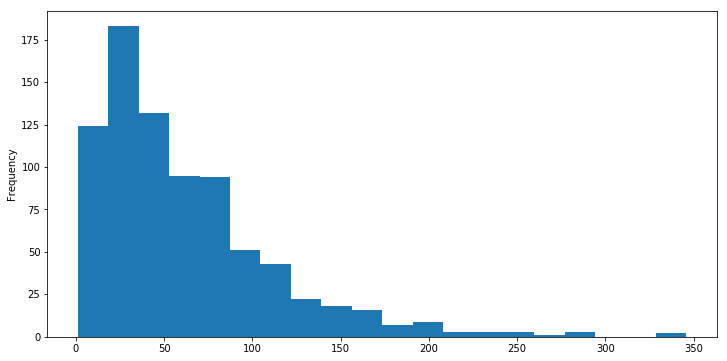

In [30]:
st_order.Quantity.plot.hist(bins = 20,figsize = (12,6));
X_bar = st_order.Quantity.mean()
X_bar

### 7.3 Does fast shipping time increase the order volume?
In order to use Bayes theorem, I must specify a prior distribution. The prior distribution is our belief as to how the system behaves. It is important to choose a prior that will not bias the results, since a poorly formed prior can greatly influence the outcome. Given that we do not have data on whether or not shipping times increase order volume for other companies, the prior that I specify cannot assume that there **is** a difference. In fact, I will specify a prior that assumes that there **is no difference** between the two datasets by using the mean and standard deviation of the joined set.
Additionally, I'll choose my cutoff at four days. From the description of the data, 25% of all orders are filled in four days, which is half the time as the expected value and leaves me with more than enough data to model. Bayesian models usually require less data to have the same statistical power since prior information is known about the system and monte carlo methods can be used to leverage the little amount of data that is available.

In [54]:
# Import libraries
import pymc3 as pm

# Define Data to use
data = st_order[['Quantity','Diff']].copy()
data['Fast'] = data.Diff <= 4

fast_group_data = data.Quantity.loc[data.Fast == True]
slow_group_data = data.Quantity.loc[data.Fast == False]

# Define Hyperparameters
µ_m = data.Quantity.mean()
µ_s = data.Quantity.std()

# Define parameter prior distributions.
with pm.Model() as model:
    fast_mean = pm.Normal('Fast Mean', μ_m, sd=μ_s)
    slow_mean = pm.Normal('Slow Mean', μ_m, sd=μ_s)
    fast_std = pm.Uniform('Fast Std', lower=30, upper=70)
    slow_std = pm.Uniform('Slow Std', lower=30, upper=70)
    nu = pm.Exponential('ν_minus_one', 1/29.) + 1 #This is a parameter for the student t

I don't have confidence about the distribution of the standard deviations, but I expect that the true standard deviation is ±20 from the current standard deviation. The use of a uniform distribution for the standard deviation parameter indicates that I have no real conviction of what the standard deviation is, except to say that it's bounded on the interval [30,70].

In [55]:
# Model the data
with model:
    lam1 = fast_std**-2
    lam2 = slow_std**-2
    fast_group = pm.StudentT('Fast Group', nu=nu, mu=fast_mean, lam=lam1, observed=fast_group_data)
    slow_group = pm.StudentT('Slow Group', nu=nu, mu=slow_mean, lam = lam2, observed=slow_group_data)

In [56]:
# Define a difference of means variable for ease of use when plotting the results
with model:
    diff_of_means = pm.Deterministic('Difference of Means', fast_mean - slow_mean)
    effect_size = pm.Deterministic('Effect Size',
                                   diff_of_means / np.sqrt((slow_std**2 + fast_std**2) / 2))

In [57]:
# Sample the data
with model:
    trace = pm.sample(4000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_minus_one, Slow Std, Fast Std, Slow Mean, Fast Mean]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:15<00:00, 583.39draws/s]
/anaconda3/envs/learn-env/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



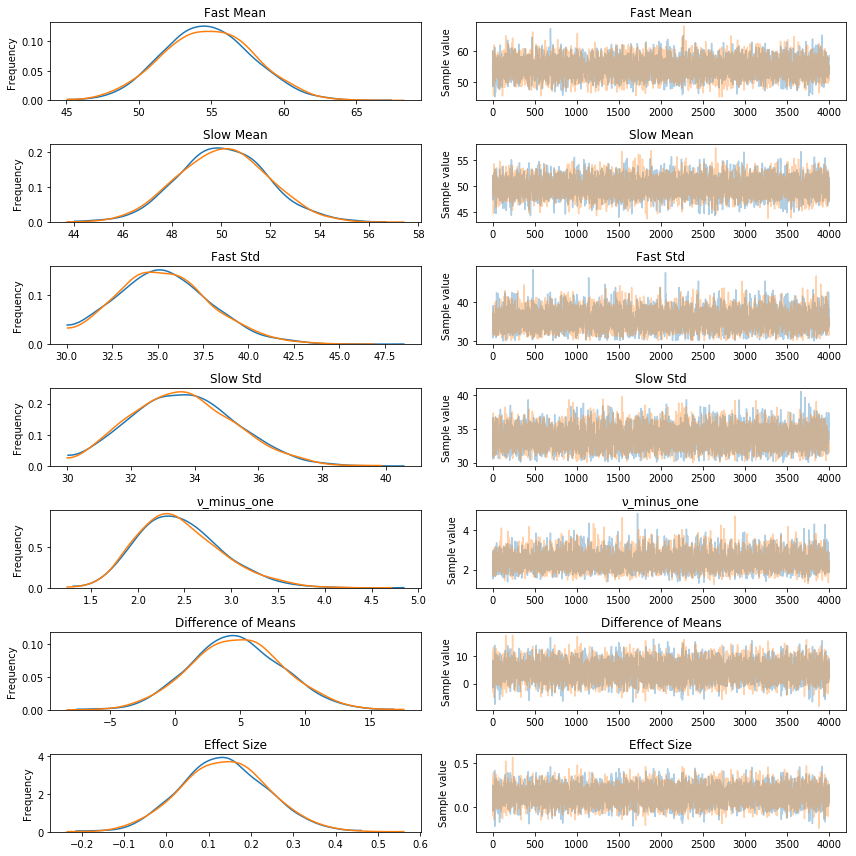

In [58]:
# Check for convergence
pm.traceplot(trace, figsize=(12,12));

It appears that every parameter converged, so I can look at the results in better detail. The difference of means is certainly shifted, but I'll have to check by how much.

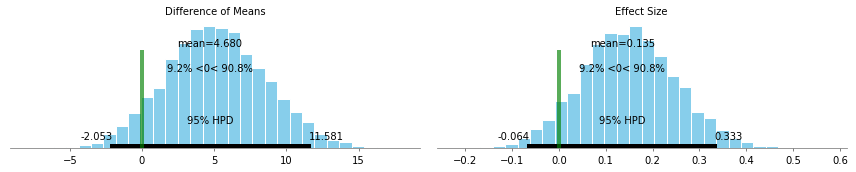

In [59]:
pm.plot_posterior(trace, varnames=['Difference of Means', 'Effect Size'], ref_val=0);

There is a $\approx$90% likelihood that there is a difference of means, though the effect size is very small. The lovely thing about the bayesian approach is that you can state your confidence directly. I am 90% confident that there is a increase in the order volume for people who obtain their goods faster. Since I established $\alpha$ = 0.05, I will conclude that I'm not confident enough to report that there is, in fact, an increase in order volume. Of course, I can (and should) report my confidence level instead to allow the business owner to make the best decision.

### 7.4 Does fast shipping increase the number of orders a customer places?
In order to perform this analysis I will modify the dataframe to reflect the average delivery time for a customer and the order count. The rest of the analysis proceeds like the one above.

In [170]:
data = st_order[['ID','Diff']].copy().groupby('ID').agg(['count','mean'])
data.columns = data.columns.droplevel()
data.columns = ['Count','ShipMean']
data.describe()

,Count,ShipMean
count,89.000000,89.000000
mean,9.089888,8.549249
std,5.672182,3.087550
min,1.000000,3.666667
25%,5.000000,7.000000
50%,8.000000,8.250000
75%,11.000000,9.727273
max,31.000000,27.500000


In [181]:
# Define Data to use
data['Fast'] = data.ShipMean <= 4 # This is in line with the reasoning for my choice above

fast_group_data = data.Count.loc[data.Fast == True]
slow_group_data = data.Count.loc[data.Fast == False]

# Define Hyperparameters
µ_m = data.Count.mean()
µ_s = data.Count.std()

# Define parameter prior distributions.
with pm.Model() as model:
    fast_mean = pm.Normal('Fast Mean', μ_m, sd=μ_s)
    slow_mean = pm.Normal('Slow Mean', μ_m, sd=μ_s)
    fast_std = pm.Uniform('Fast Std', lower=4, upper=7)
    slow_std = pm.Uniform('Slow Std', lower=4, upper=7)
    nu = pm.Exponential('ν_minus_one', 1/29.) + 1 #This is a parameter for the student ts

In [182]:
# Define a difference of means variable for ease of use when plotting the results
with model:
    diff_of_means = pm.Deterministic('Difference of Means', fast_mean - slow_mean)
    effect_size = pm.Deterministic('Effect Size',
                                   diff_of_means / np.sqrt((slow_std**2 + fast_std**2) / 2))

In [183]:
# Sample the data
with model:
    trace = pm.sample(4000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_minus_one, Slow Std, Fast Std, Slow Mean, Fast Mean]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:10<00:00, 889.83draws/s] 
/anaconda3/envs/learn-env/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



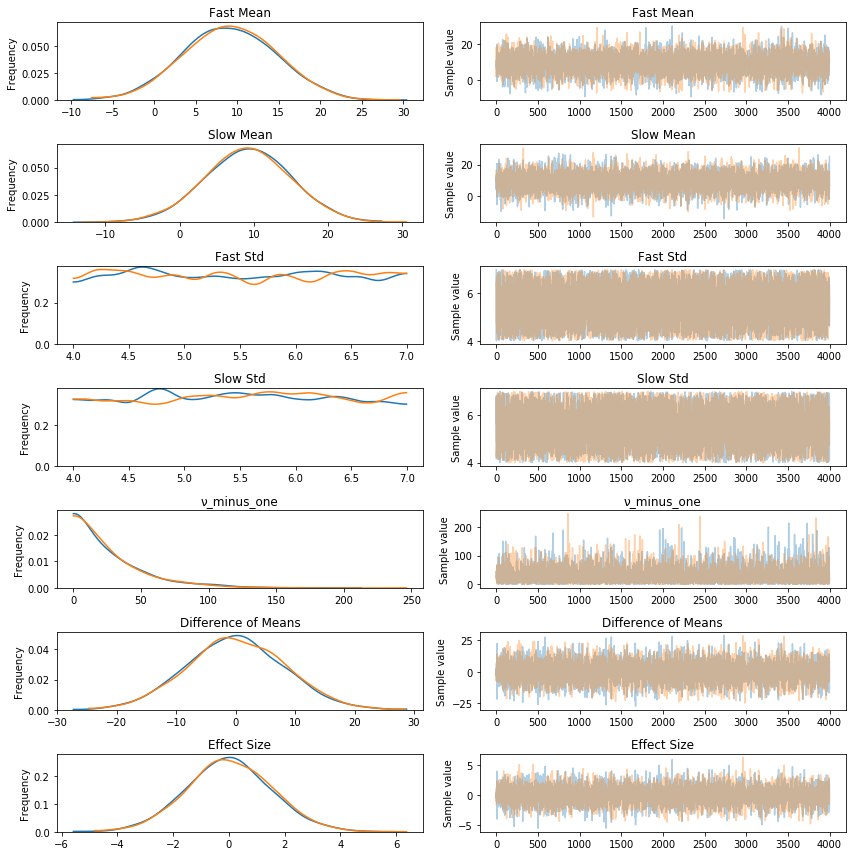

In [184]:
# Check for convergence
pm.traceplot(trace, figsize=(12,12));

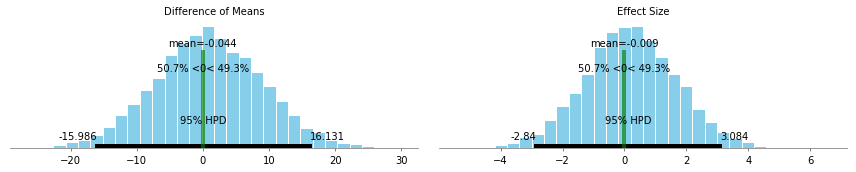

In [185]:
pm.plot_posterior(trace, varnames=['Difference of Means', 'Effect Size'], ref_val=0);

The results are almost impossibly equivocal. The speed with which a customer's order is delivered has no impact on the number of orders that the customer places. So it turns out that the number of items ordered does increase with fast shipp